# Embedding
- [MLB & Prepare](#MLB-and-Prepare)</BR>
- [Embed body](#Embed-Body)</BR>
- [Embed Title](#Embed-Title)</BR>
- [Embed LSTM Body](#Embed-LSTM-Body)</BR>
- [Concatenation](#Embed-Concatenation)</BR>

In [1]:
import importlib
import os
from joblib import dump, load

import numpy as np
import pandas as pd

import tensorflow as tf

from sklearn.preprocessing import MultiLabelBinarizer

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import matplotlib.pyplot as plt

data_path = "..\\data\\stackoverflow\\"
model_path = data_path + "models\\"

np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = "{:,.2f}".format

# https://github.com/tensorflow/text/issues/476

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


# MLB and Prepare
- [Toc](#Embedding)

In [2]:
df_lemma = pd.read_pickle(data_path + 'nltk_lemma_stop.pkl')
df_lemma_test = pd.read_pickle(data_path + 'nltk_lemma_stop_test.pkl')
df_lemma['Title'] = df_lemma['Title'].apply(lambda row: ' '.join(row))
df_lemma['Body'] = df_lemma['Body'].apply(lambda row: ' '.join(row))
df_lemma_test['Title'] = df_lemma_test['Title'].apply(lambda row: ' '.join(row))
df_lemma_test['Body'] = df_lemma_test['Body'].apply(lambda row: ' '.join(row))

In [3]:
mlb = MultiLabelBinarizer()
df_tags = pd.read_pickle(data_path + 'Top_Tags.pkl')
df_tags_test = pd.read_pickle(data_path + 'Top_Tags_test.pkl')
df_tags_full = pd.concat([df_tags,df_tags_test])
mlb.fit_transform(df_tags_full['Tags_T50'])

y_tags = mlb.transform(df_tags['Tags_T50'])
y_tags_test = mlb.transform(df_tags_test['Tags_T50'])

y_tag_python = y_tags[:,np.where(mlb.classes_=="python")]

save_mlb = False
if save_mlb:
    dump(mlb, model_path + "LSTM_model\\mlb.joblib")

# Embed Body
- [Toc](#Embedding)

In [4]:
COUNT = 100000
SPLIT_RATIO = .8
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

ds_body =  tf.data.Dataset.from_tensor_slices((df_lemma['Body'][:COUNT], y_tags[:COUNT]))
ds_body_train, ds_body_valid = ds_body.take(ds_body.cardinality().numpy()*SPLIT_RATIO), ds_body.skip(ds_body.cardinality().numpy()*SPLIT_RATIO)
body_train_data = ds_body_train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
body_valid_data = ds_body_valid.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [5]:
VOCAB_SIZE = 5000
# SEQUENCE_LENGTH = 128
SEQUENCE_LENGTH = 128
# NGRAMS=(1,2)
NGRAMS=None

vectorize_layer = TextVectorization(
#     standardize=custom_standardization,
#     input_shape=(4000,),
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH,
    ngrams=NGRAMS,)

metrics = [
    tf.keras.metrics.PrecisionAtRecall(0.4, name='patr'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.FalsePositives(name='fp'),
#     tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
#     tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

# text_ds = train_data.map(lambda x, y: x)
text_ds = body_train_data.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

In [6]:
# EMBEDDING_DIM = 48
EMBEDDING_DIM = 48
DROPOUT = .35
LABEL_SMOOTHING =0

model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, name="embedding"),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(EMBEDDING_DIM,
            activation='relu',
                ),
    tf.keras.layers.Dropout(DROPOUT),
#     tf.keras.layers.Dense(EMBEDDING_DIM, activation='relu', 
#                 ),
#     tf.keras.layers.Dropout(DROPOUT),
    tf.keras.layers.Dense(51, activation='sigmoid'),
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.003)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.03)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING),
    metrics=metrics,
)
# model.summary()

In [7]:
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=4,
    restore_best_weights=True,
    )

history = model.fit(
    body_train_data,
    epochs=10,
    validation_data=body_valid_data,
    callbacks=[es_callback],
)

Epoch 1/10
2411/2411 [==============================] - 65s 26ms/step - loss: 0.1498 - patr: 0.0901 - recall: 0.0130 - auc: 0.7147 - fp: 4269.9279 - fn: 56614.5170 - tp: 748.0643 - accuracy: 0.9648 - precision: 0.1124 - val_loss: 0.0914 - val_patr: 0.3449 - val_recall: 0.0992 - val_auc: 0.8989 - val_fp: 1889.0000 - val_fn: 25923.0000 - val_tp: 2854.0000 - val_accuracy: 0.9717 - val_precision: 0.6017
Epoch 2/10
2411/2411 [==============================] - 74s 31ms/step - loss: 0.0882 - patr: 0.3919 - recall: 0.1294 - auc: 0.9045 - fp: 4331.5842 - fn: 49177.4067 - tp: 8185.1920 - accuracy: 0.9726 - precision: 0.6343 - val_loss: 0.0734 - val_patr: 0.6202 - val_recall: 0.2266 - val_auc: 0.9405 - val_fp: 1929.0000 - val_fn: 22257.0000 - val_tp: 6520.0000 - val_accuracy: 0.9754 - val_precision: 0.77178 - auc: 0.9044 - fp: 4255.4909 - fn: 48465.0682 - tp: 8008.4728 - accuracy: 0.9726 - 
Epoch 3/10
2411/2411 [==============================] - 73s 30ms/step - loss: 0.0735 - patr: 0.6082 - recal

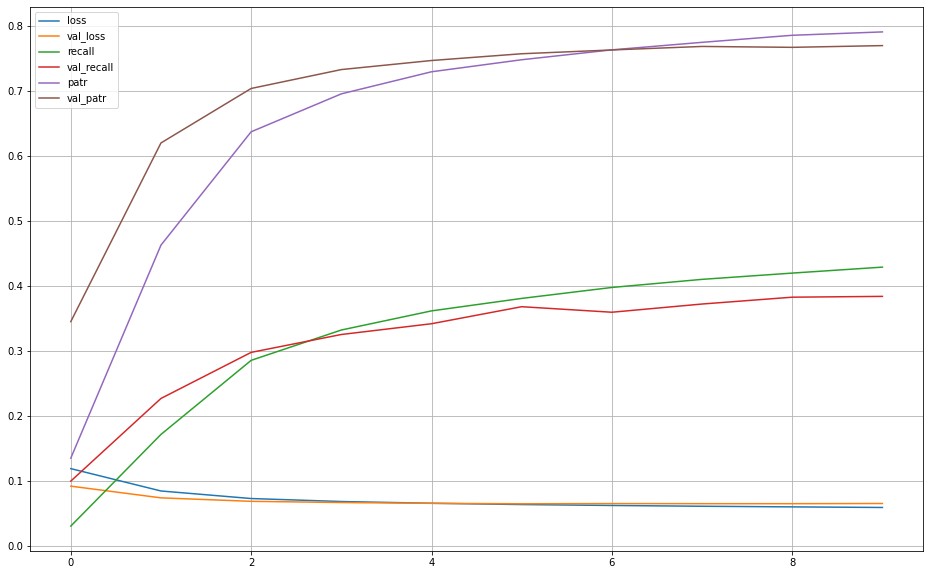

In [8]:
cols_1 = ['loss', 'val_loss', 'recall', 'val_recall', 'patr', 'val_patr' ]
pd.DataFrame(history.history)[cols_1].plot(figsize=(16,10))
plt.grid(True)
# plt.gca().set_ylim(0,1)
plt.show()

In [12]:
model.evaluate(df_lemma_test['Body'], y_tags_test)

433/433 [==============================] - 8s 19ms/step - loss: 0.0650 - patr: 0.7726 - recall: 0.3817 - auc: 0.9490 - fp: 2133.0000 - fn: 12874.0000 - tp: 7946.0000 - accuracy: 0.9787 - precision: 0.7884: 0s - loss: 0.0650 - patr: 0.7725 - recall: 0.3817 - auc: 0.9490 - fp: 2132.0000 - fn: 12863.0000 - tp: 7942.0000 - accuracy: 0.9787 - precision: 0.788


[0.06500200927257538,
 0.7725595235824585,
 0.38165226578712463,
 0.9490290284156799,
 2133.0,
 12874.0,
 7946.0,
 0.9787322282791138,
 0.7883718609809875]

# Embed Title
- [Toc](#Embedding)

In [42]:
COUNT = 100000
SPLIT_RATIO = .8
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

ds_title =  tf.data.Dataset.from_tensor_slices((df_lemma['Title'][:COUNT], y_tags[:COUNT]))
ds_title_train, ds_title_valid = ds_title.take(ds_title.cardinality().numpy()*SPLIT_RATIO), ds_title.skip(ds_title.cardinality().numpy()*SPLIT_RATIO)
title_train_data = ds_title_train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
title_valid_data = ds_title_valid.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [43]:
VOCAB_SIZE = 1000
# SEQUENCE_LENGTH = 128
SEQUENCE_LENGTH = 32
# NGRAMS=(1,2)
NGRAMS=None

vectorize_layer = TextVectorization(
#     standardize=custom_standardization,
#     input_shape=(4000,),
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH,
#     ngrams=NGRAMS,
    )

metrics = [
    tf.keras.metrics.PrecisionAtRecall(0.4, name='patr'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.FalsePositives(name='fp'),
#     tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
#     tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

# text_ds = train_data.map(lambda x, y: x)
text_ds = title_train_data.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

In [44]:
EMBEDDING_DIM = 32
DROPOUT = .25
LABEL_SMOOTHING =0

model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, name="embedding"),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(EMBEDDING_DIM,
            activation='relu',
                ),
    tf.keras.layers.Dropout(DROPOUT),
#     tf.keras.layers.Dense(EMBEDDING_DIM, activation='relu', 
#                 ),
#     tf.keras.layers.Dropout(DROPOUT),
    tf.keras.layers.Dense(51, activation='sigmoid'),
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.03)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING),
    metrics=metrics,
)
# model.summary()

In [45]:
history = model.fit(
    title_train_data,
    epochs=5,
    validation_data=title_valid_data,
    restore_best_weights=True,
)

Epoch 1/5
2411/2411 [==============================] - 34s 14ms/step - loss: 0.1217 - patr: 0.1792 - recall: 0.0804 - auc: 0.7956 - fp: 3530.6808 - fn: 50857.3843 - tp: 6505.1716 - accuracy: 0.9698 - precision: 0.4622 - val_loss: 0.0673 - val_patr: 0.7897 - val_recall: 0.3536 - val_auc: 0.9419 - val_fp: 1928.0000 - val_fn: 18601.0000 - val_tp: 10176.0000 - val_accuracy: 0.9791 - val_precision: 0.8407
Epoch 2/5
2411/2411 [==============================] - 32s 13ms/step - loss: 0.0697 - patr: 0.7532 - recall: 0.3629 - auc: 0.9358 - fp: 5377.5854 - fn: 36225.7496 - tp: 21136.9772 - accuracy: 0.9787 - precision: 0.7940 - val_loss: 0.0634 - val_patr: 0.8369 - val_recall: 0.3953 - val_auc: 0.9490 - val_fp: 2096.0000 - val_fn: 17402.0000 - val_tp: 11375.0000 - val_accuracy: 0.9802 - val_precision: 0.8444
Epoch 3/5
2411/2411 [==============================] - 32s 13ms/step - loss: 0.0663 - patr: 0.7936 - recall: 0.3899 - auc: 0.9428 - fp: 5426.5945 - fn: 34934.2641 - tp: 22428.5460 - accuracy:

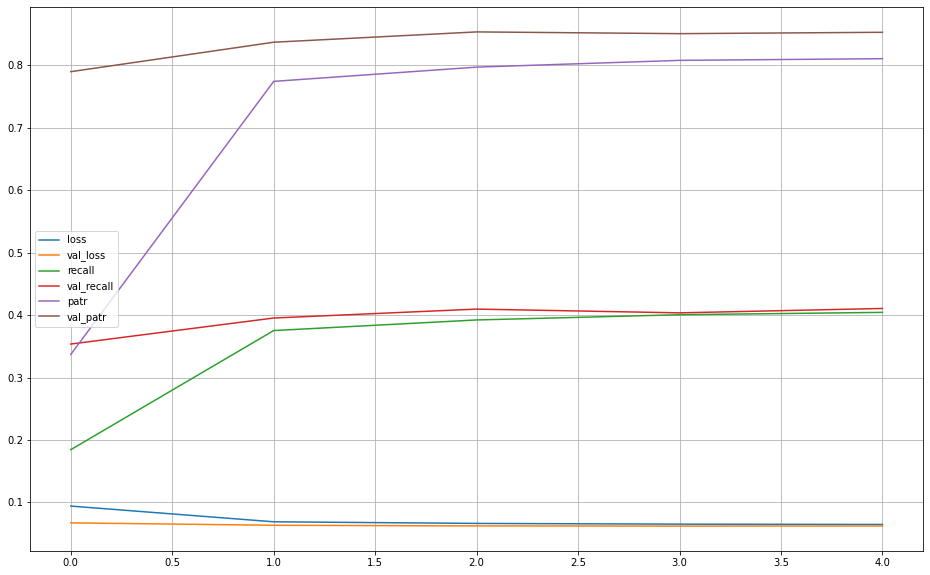

In [46]:
cols_1 = ['loss', 'val_loss', 'recall', 'val_recall', 'patr', 'val_patr' ]
pd.DataFrame(history.history)[cols_1].plot(figsize=(16,10))
plt.grid(True)
# plt.gca().set_ylim(0,1)
plt.show()

# Embed LSTM Body
- [Toc](#Embedding)

In [4]:
COUNT = 100000
SPLIT_RATIO = .8
BATCH_SIZE = 16
SHUFFLE_BUFFER_SIZE = 128

ds_body =  tf.data.Dataset.from_tensor_slices((df_lemma['Body'][:COUNT], y_tags[:COUNT]))
ds_body_train, ds_body_valid = ds_body.take(ds_body.cardinality().numpy()*SPLIT_RATIO), ds_body.skip(ds_body.cardinality().numpy()*SPLIT_RATIO)
body_train_data = ds_body_train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
body_valid_data = ds_body_valid.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [5]:
VOCAB_SIZE = 5000
SEQUENCE_LENGTH = 64
# NGRAMS=(1,2)

vectorize_layer = TextVectorization(
#     standardize=custom_standardization,
    max_tokens=VOCAB_SIZE,
    output_mode='int',
#     ngrams=NGRAMS,
    output_sequence_length=SEQUENCE_LENGTH,
    )

text_ds = body_train_data.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

In [8]:
EMBEDDING_DIM = 48
DROPOUT = .4
LABEL_SMOOTHING =0

model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMBEDDING_DIM,
#         mask_zero=True,
        name="embedding"),
#     tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        EMBEDDING_DIM,
#         recurrent_dropout=0.1,
    )),
    tf.keras.layers.Dense(EMBEDDING_DIM,
            activation='relu',
                ),
#     tf.keras.layers.Dropout(DROPOUT),
#     tf.keras.layers.Dense(EMBEDDING_DIM, activation='relu', 
#                 ),
    tf.keras.layers.Dropout(DROPOUT),
    tf.keras.layers.Dense(51, activation='sigmoid'),
])

metrics = [
    tf.keras.metrics.PrecisionAtRecall(0.4, name='patr'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.FalsePositives(name='fp'),
#     keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
#     keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

optimizer = tf.keras.optimizers.Adamax(learning_rate=0.03)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING),
    metrics=metrics,
)
# model.summary()

In [9]:
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=3,
    restore_best_weights=True,
    )


history = model.fit(
    body_train_data,
    epochs=8,
    validation_data=body_valid_data,
    callbacks=[es_callback],
)

Epoch 1/8
4821/4821 [==============================] - 167s 34ms/step - loss: 0.1087 - patr: 0.2248 - recall: 0.0850 - auc: 0.8158 - fp: 3902.5811 - fn: 50808.5336 - tp: 6518.4000 - accuracy: 0.9708 - precision: 0.5111 - val_loss: 0.0694 - val_patr: 0.6987 - val_recall: 0.2980 - val_auc: 0.9445 - val_fp: 2435.0000 - val_fn: 20201.0000 - val_tp: 8576.0000 - val_accuracy: 0.9770 - val_precision: 0.7789
Epoch 2/8
4821/4821 [==============================] - 332s 69ms/step - loss: 0.0711 - patr: 0.6623 - recall: 0.3233 - auc: 0.9392 - fp: 6818.3353 - fn: 38182.6914 - tp: 19144.5742 - accuracy: 0.9769 - precision: 0.7331 - val_loss: 0.0631 - val_patr: 0.7796 - val_recall: 0.3767 - val_auc: 0.9530 - val_fp: 2741.0000 - val_fn: 17936.0000 - val_tp: 10841.0000 - val_accuracy: 0.9790 - val_precision: 0.7982 - patr: 0.6622 - recall: 0.3233 - auc: 0.9392 - fp: 6799.1824 - fn: 38083.3651 - tp: 19087.7569 - accuracy: 
Epoch 3/8
4821/4821 [==============================] - 332s 69ms/step - loss: 0.0

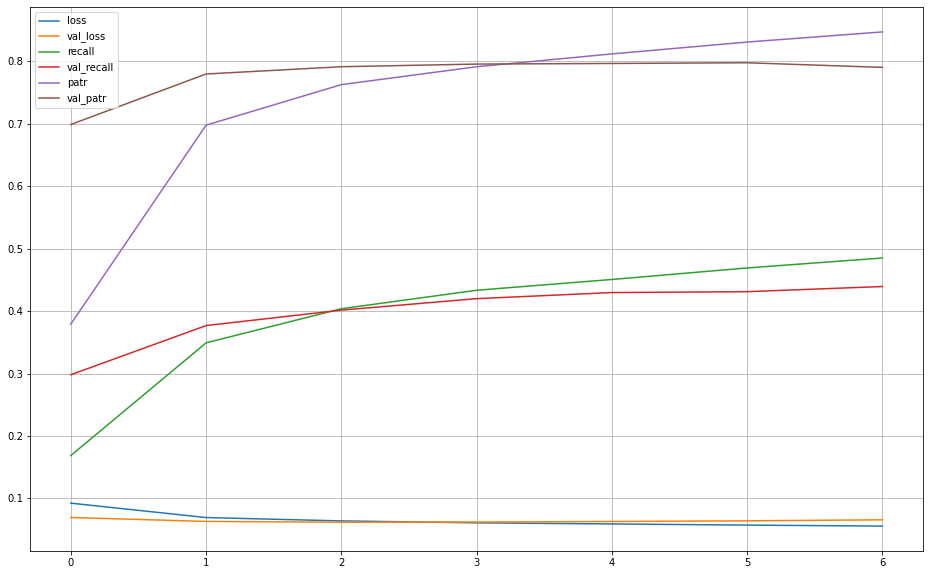

In [10]:
cols_1 = ['loss', 'val_loss', 'recall', 'val_recall', 'patr', 'val_patr' ]
pd.DataFrame(history.history)[cols_1].plot(figsize=(16,10))
plt.grid(True)
# plt.gca().set_ylim(0,1)
plt.show()

In [11]:
ds_body_test =  tf.data.Dataset.from_tensor_slices((df_lemma_test['Body'], y_tags_test))
body_test_data = ds_body_test.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [12]:
model.evaluate(body_test_data)


865/865 [==============================] - 30s 35ms/step - loss: 0.0617 - patr: 0.7979 - recall: 0.4052 - auc: 0.9550 - fp: 2174.0000 - fn: 12383.0000 - tp: 8437.0000 - accuracy: 0.9794 - precision: 0.7951


[0.06169230863451958,
 0.7978937029838562,
 0.4052353501319885,
 0.9550477266311646,
 2174.0,
 12383.0,
 8437.0,
 0.9793713092803955,
 0.7951182723045349]

In [88]:
inverse_vocab = vectorize_layer.get_vocabulary()
print(inverse_vocab[:20])

['', '[UNK]', 'like', 'get', 'work', 'value', 'data', 'function', 'file', 'error', 'column', 'example', 'create', 'make', 'look', 'add', 'output', 'list', 'result', 'run']


In [99]:
ds_test = ds_body_test.map(lambda x,y: x)

In [100]:
text_vector_ds = ds_test.batch(1024).prefetch(tf.data.experimental.AUTOTUNE).map(vectorize_layer).unbatch()

In [101]:
sequences = list(text_vector_ds.as_numpy_iterator())
for seq in sequences[:5]:
    print(f"{seq} => {[inverse_vocab[i] for i in seq]}")

[  13 1035 1501    1    2    1  661  169  192  216 1501 1446  342   70
   14   70  496   86 1035  403  233  403  170  487  581  298  298  298
  170  369   12    1 1035  259    2    1  520   13 1035   40    2  661
   80   47  161  122    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0] => ['make', 'border', 'curve', '[UNK]', 'like', '[UNK]', 'picture', 'achieve', 'put', 'content', 'curve', 'corner', 'allow', 'go', 'look', 'go', 'site', 'page', 'border', 'background', 'color', 'background', 'currently', 'snippet', 'switch', 'tag', 'tag', 'tag', 'currently', 'produce', 'create', '[UNK]', 'border', 'around', 'like', '[UNK]', 'div', 'make', 'border', 'class', 'like', 'picture', 'another', 'method', 'anyone', 'idea', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
[3713 1261   49  509    5   78  690  238  509 1261  250 1383   49    5
 1261   25  266  690  467   78   49  266  690 1613   78  467   25  306
  830    0    0    0    0

In [102]:
weights = model.get_layer('embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

In [104]:
import io
out_v = io.open(model_path + 'vectors.tsv', 'w', encoding='utf-8')
out_m = io.open(model_path + 'metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
    if index == 0:
        continue  # skip 0, it's padding.
    vec = weights[index]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
out_v.close()
out_m.close()

# Embed Concatenation
- [Toc](#Embedding)

In [4]:
LABEL_SMOOTHING = 0
loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING)

In [5]:
COUNT=100000
SPLIT_RATIO = .8
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 128
ds_concat =  tf.data.Dataset.from_tensor_slices(((df_lemma['Title'][:COUNT], df_lemma['Body'][:COUNT]), y_tags[:COUNT]))
ds_concat_train, ds_concat_valid = ds_concat.take(ds_concat.cardinality().numpy()*SPLIT_RATIO), ds_concat.skip(ds_concat.cardinality().numpy()*SPLIT_RATIO)
concat_train_data = ds_concat_train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
concat_valid_data = ds_concat_valid.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [6]:
metrics = [
    tf.keras.metrics.PrecisionAtRecall(0.5, name='patr'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.FalsePositives(name='fp'),
#     tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
#     tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [7]:
TITLE_VOCAB_SIZE = 1000
TITLE_SEQUENCE_LENGTH = 32
title_vectorize_layer = TextVectorization(
    standardize = None,
    max_tokens=TITLE_VOCAB_SIZE,
    output_mode='int',
#     output_sequence_length=TITLE_SEQUENCE_LENGTH,
    name="title_vector",
    )
# title_text_ds = concat_train_data.map(lambda x, y: x)
title_vectorize_layer.adapt(df_lemma['Title'][:COUNT].values)

BODY_VOCAB_SIZE = 5000
BODY_SEQUENCE_LENGTH = 72
body_vectorize_layer = TextVectorization(
    standardize = None,
    max_tokens=BODY_VOCAB_SIZE,
    output_mode='int',
#     output_sequence_length=BODY_SEQUENCE_LENGTH,
    name="body_vector"
    )
# body_text_ds = concat_train_data.map(lambda x, y: x)
body_vectorize_layer.adapt(df_lemma['Body'][:COUNT].values)

In [8]:
TITLE_DIM = 32
LSTM_DIM = 56
BODY_EMBED_DIM = 48
CONCAT_DIM = 48

TITLE_DROPOUT = .25
LSTM_DROPOUT = .30
CONCAT_DROPOUT = .30

input_title = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name="title_input")
vect_title = title_vectorize_layer(input_title)
embed_title = tf.keras.layers.Embedding(TITLE_VOCAB_SIZE, TITLE_DIM, name="title_embed")(vect_title)
pool1D_title = tf.keras.layers.GlobalAveragePooling1D(name="title_pool1")(embed_title)
dropout_title = tf.keras.layers.Dropout(TITLE_DROPOUT, name="title_dropout")(pool1D_title)
# hidden_title_2 = tf.keras.layers.Dense(DIM_TITLE, activation='relu')(dropout_title_1)
# dropout_title_2 = tf.keras.layers.Dropout(DROPOUT)(hidden_title_2)

input_body = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name="body_input")
vect_body = body_vectorize_layer(input_body)
embed_body = tf.keras.layers.Embedding(
        input_dim=BODY_VOCAB_SIZE,
        output_dim=BODY_EMBED_DIM,
        name="embedding")(vect_body)
LSTM_body = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        LSTM_DIM, name='LSTM'
    ),name='BIDI_LSTM')(embed_body)
dropout_body = tf.keras.layers.Dropout(LSTM_DROPOUT, name="LSTM_dropout")(LSTM_body)

concat = tf.keras.layers.concatenate([dropout_title, dropout_body], name="concat")
hidden_concat = tf.keras.layers.Dense(CONCAT_DIM, activation='relu', name="concat_hidden")(concat)
dropout_concat = tf.keras.layers.Dropout(CONCAT_DROPOUT, name="concat_dropout")(hidden_concat)
output = tf.keras.layers.Dense(51, activation='sigmoid', name="concat_activation")(dropout_concat)
model = tf.keras.Model(inputs=[input_title, input_body], outputs=[output])

optimizer = tf.keras.optimizers.Adamax(learning_rate=0.03)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING),
    metrics=metrics,
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
body_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
title_vector (TextVectorization (None, None)         0           title_input[0][0]                
__________________________________________________________________________________________________
body_vector (TextVectorization) (None, None)         0           body_input[0][0]                 
______________________________________________________________________________________________

In [9]:
# tb_callback = tf.keras.callbacks.TensorBoard(tb_logdir())
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=3,
    restore_best_weights=True,
    )

history = model.fit(
    concat_train_data,
    epochs=8,
    validation_data=concat_valid_data,
#     validation_steps=3,
    callbacks=[es_callback],
)

Epoch 1/8
2411/2411 [==============================] - 129s 50ms/step - loss: 0.0997 - patr: 0.2609 - recall: 0.1619 - auc: 0.8526 - fp: 5517.9241 - fn: 45411.1219 - tp: 11951.0220 - accuracy: 0.9716 - precision: 0.5763 - val_loss: 0.0556 - val_patr: 0.7768 - val_recall: 0.4489 - val_auc: 0.9664 - val_fp: 2936.0000 - val_fn: 15860.0000 - val_tp: 12917.0000 - val_accuracy: 0.9809 - val_precision: 0.8148
Epoch 2/8
2411/2411 [==============================] - 243s 101ms/step - loss: 0.0595 - patr: 0.7253 - recall: 0.4489 - auc: 0.9578 - fp: 7657.6032 - fn: 31060.2392 - tp: 26302.7492 - accuracy: 0.9801 - precision: 0.7701 - val_loss: 0.0505 - val_patr: 0.8286 - val_recall: 0.5260 - val_auc: 0.9708 - val_fp: 3425.0000 - val_fn: 13640.0000 - val_tp: 15137.0000 - val_accuracy: 0.9826 - val_precision: 0.8155
Epoch 3/8
2411/2411 [==============================] - 257s 106ms/step - loss: 0.0540 - patr: 0.7892 - recall: 0.5046 - auc: 0.9657 - fp: 7836.7575 - fn: 28172.4465 - tp: 29190.3881 - acc

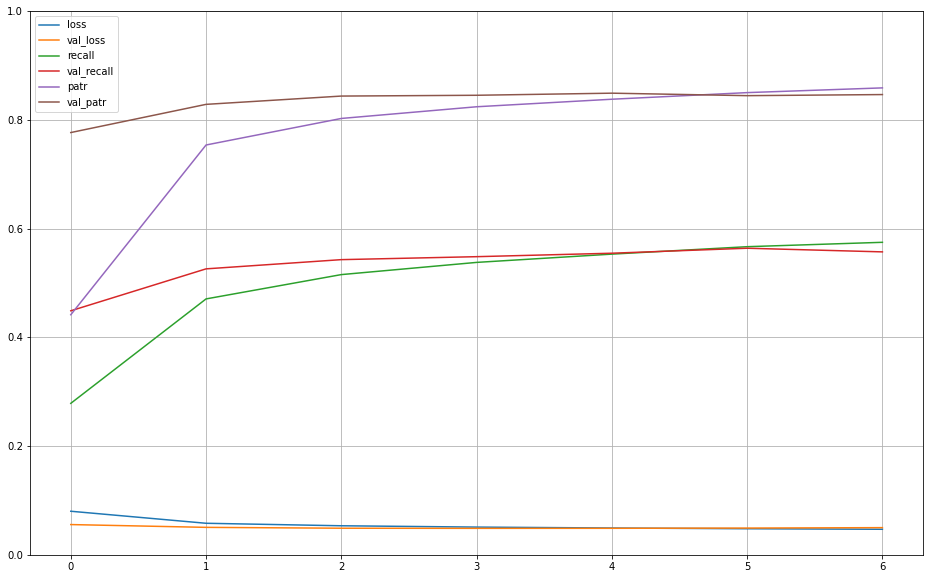

In [10]:
cols_1 = ['loss', 'val_loss', 'recall', 'val_recall', 'patr', 'val_patr' ]
pd.DataFrame(history.history)[cols_1].plot(figsize=(16,10))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [4]:
save=False
if save:
    model.save(model_path + "LSTM_model", overwrite=True, include_optimizer=True)
    saved_model = model
#     model.save_weights(model_path + "LSTM_weights")
else:
    saved_model = tf.keras.models.load_model(model_path + "LSTM_model")

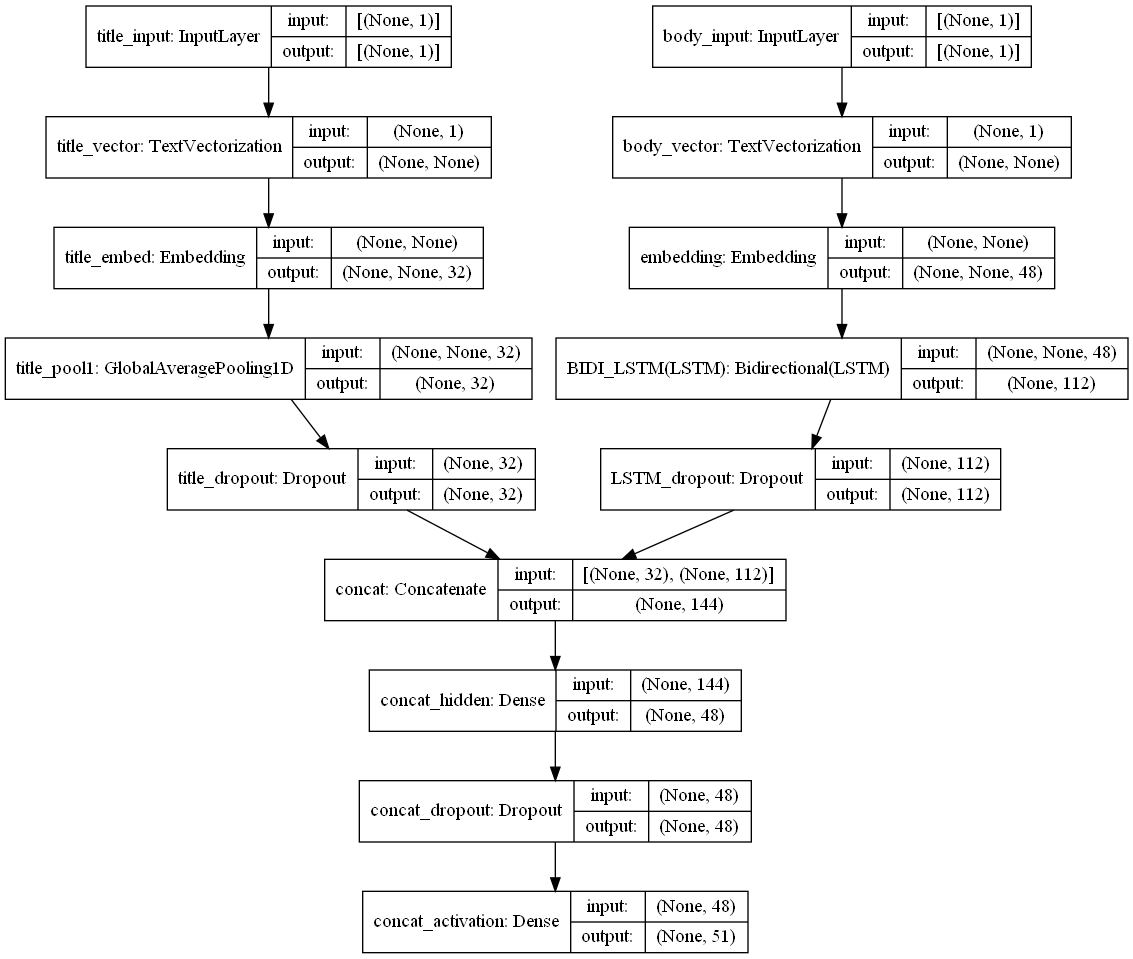

In [9]:
tf.keras.utils.plot_model(saved_model, show_shapes=True, rankdir='TB', dpi=96, to_file=data_path + "pict_MODEL_LSTM.png")

In [13]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 128
ds_concat_test =  tf.data.Dataset.from_tensor_slices(((df_lemma_test['Title'], df_lemma_test['Body']), y_tags_test))
concat_test_data = ds_concat_test.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [15]:
# saved_model.evaluate(concat_test_data)
model.evaluate(concat_test_data)

433/433 [==============================] - 20s 47ms/step - loss: 0.0492 - patr: 0.8473 - recall: 0.5503 - auc: 0.9708 - fp: 2575.0000 - fn: 9363.0000 - tp: 11457.0000 - accuracy: 0.9831 - precision: 0.8165


[0.049202434718608856,
 0.8473411798477173,
 0.550288200378418,
 0.970772922039032,
 2575.0,
 9363.0,
 11457.0,
 0.9830817580223083,
 0.816490888595581]

In [15]:
dst = tf.data.Dataset.from_tensor_slices(["panda dataframe"])
dsb = tf.data.Dataset.from_tensor_slices(["panda"])
dspred = tf.data.Dataset.zip(((dst, dsb),)).batch(10)
res = saved_model.predict(dspred)

In [18]:
for z in np.arange(res.shape[0]):
    classes = ""
    for r in np.arange(len(mlb.classes_)):
        if res[z][r]>.05:
            classes = classes + mlb.classes_[r] + ", "
            print("r:", r , "value:", res[z][r])            
    print("classe: ", classes )

r: 10 value: 0.91260195
r: 32 value: 1.0
r: 36 value: 0.9995401
r: 37 value: 0.09092887
classe:  dataframe, pandas, python, python-3.x, 


In [10]:
mlb.inverse_transform(y_tags[8750:8760])

[('amazon-web-services', 'python'),
 ('python',),
 ('r',),
 ('pandas', 'python'),
 ('c',),
 ('amazon-web-services',),
 ('arrays', 'javascript', 'typescript'),
 ('c#',),
 ('java',),
 ('css',)]

In [23]:
dst = tf.data.Dataset.from_tensor_slices(df_lemma['Title'][2458:2459])
dsb = tf.data.Dataset.from_tensor_slices(df_lemma['Body'][2458:2459])
dspred = tf.data.Dataset.zip(((dst, dsb),)).batch(10)
print(df_lemma['Title'][2458:2459].values)
print(df_lemma['Body'][2458:2459].values)

['combine two sql query different condition']
['write query find number student gender particular class unable find write query gender write query two time gender combine union either query result query result output like preferably single query thank']


In [19]:
threshold=.2

In [27]:
res = model.predict(dspred)
for z in np.arange(res.shape[0]):
    classes = ""
    for r in np.arange(len(mlb.classes_)):
        if res[z][r]>.15:
            print("r:", r , "value:", saved_res[z][r])
            classes = classes + mlb.classes_[r] + ", "
    print("classe: ", classes )

r: 28 value: 0.306385
r: 42 value: 0.89516944
r: 43 value: 0.17051384
classe:  mysql, sql, sql-server, 


In [24]:
saved_res = saved_model.predict(dspred)
for z in np.arange(saved_res.shape[0]):
    classes = ""
    for r in np.arange(len(mlb.classes_)):
        if saved_res[z][r]>.15:
            print("r:", r , "value:", saved_res[z][r])
            classes = classes + mlb.classes_[r] + ", "
    print("classe: ", classes )

r: 28 value: 0.306385
r: 42 value: 0.89516944
r: 43 value: 0.17051384
classe:  mysql, sql, sql-server, 


In [22]:
mlb.inverse_transform(y_tags[10:20])

[('python',),
 ('other',),
 ('c++',),
 ('matplotlib', 'python'),
 ('python',),
 ('amazon-web-services',),
 ('css', 'html', 'javascript'),
 ('pandas', 'python'),
 ('javascript',),
 ('list', 'python-3.x')]

In [72]:
df_lemma['Title'][15:16].values

array(['restrict s3 sub folder level bucket policy private public'],
      dtype=object)

In [14]:
print (mlb.classes_[38])

r


In [ ]:
res = model.predict(X_test[8750:8760])
